In [ ]:
# Copyright 2022 NVIDIA Corporation. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

<img src="http://developer.download.nvidia.com/notebooks/dlsw-notebooks/tensorrt_torchtrt_qat_ptq_workflow/nvidia_logo.png" width="90px">

# Accelerate Deep Learning Models using Torch-TensorRT 

## Overview

Deep Learning has touched almost every industry and has transformed the way industries operate and provide services. We perform or experience real-time analytics all the time around us, for example, an advertisement that you saw while swiping through the stories on Instagram, or the video recommendation that floated on your youtube home screen. To cater to these real-time inferences, deep learning practitioners need to maximise model throughput while having highly accurate predictions. Quantization amongst many techniques employed, let's have a look at how it can be used to accelerate models.

Model Quantization is a popular way of optimization which reduces the size of models thereby accelerating inference, also opening up the possibilities of deployments on devices with lower computation power such as Jetson. Simply put, quantization is a process of mapping input values from a larger set to output values in a smaller set. In the context of deep learning, we often train deep learning models using floating-point 32 bit arithmetic (FP32) as we can take advantage of a wider range of numbers, catering to higher precision. The model data–network parameters and activations–are converted from this floating point representation to a lower precision representation, typically using 8-bit integers (int8). In the case of int8, the range [qmin, qmax] would be [-128, 127].

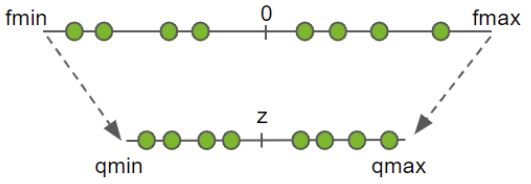

A quick rationale of how quantization's throughput is acheived by the following thought experiment: Imagine the complexity of multiplying 3.999x2.999 and 4x3. The latter is easier to perform than the former. This is the simplicity in calculation seen by quantizing the numbers to lower precision. But the challenge here is that this rounding off can result in a lower accuracy model. To address this loss of accuracy, different quantization techniques have been developed. These techniques can be classified into two categories, post-training quantization (PTQ) and quantization-aware training (QAT).

In this notebook, we illustrate the workflow that you can adopt while quantizing a deep learning model in Torch-TensorRT. The notebook takes you through an example of Mobilenetv2 for a classification task on a subset of Imagenet Dataset called Imagenette which has 10 classes.  

1. [Requirements](#1)
2. [Setup a baseline Mobilenetv2 model](#2)
3. [Convert to Torch TRT](#3)
4. [Post Training Quantization (PTQ)](#4)
4. [Quantization Aware training](#4)
5. [Export to Torchscript](#5)
6. [Inference using Torch-TensorRT](#6)
7. [References](#7)

This notebook is implemented using the NGC pytorch container nvcr.io/nvidia/pytorch:22.04-py3. Follow instructions here https://ngc.nvidia.com/setup/api-key to setup your own API key to use the NGC service through the Docker client. 

<a id="1"></a>
##  1. Requirements
Please install the <a href="https://github.com/NVIDIA/Torch-TensorRT/tree/master/examples/int8/training/vgg16#prequisites">required dependencies</a> and import these libraries accordingly

In [23]:
%pip install ipywidgets --trusted-host pypi.org --trusted-host pypi.python.org --trusted-host=files.pythonhosted.org
%pip install wget
%pip install torch_tensorrt
%pip install tensorrt
%pip install pytorch-quantization --extra-index-url https://pypi.ngc.nvidia.com

In [2]:
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
print(torch.__version__)

import torchvision.transforms as transforms
from torchvision import models, datasets
import torch_tensorrt
print(torch_tensorrt.__version__)

import pytorch_quantization
from pytorch_quantization import nn as quant_nn
from pytorch_quantization import quant_modules
from pytorch_quantization.tensor_quant import QuantDescriptor
from pytorch_quantization import calib
print(pytorch_quantization.__version__)

from tqdm import tqdm

import os
import sys
import warnings
import time
import numpy as np
import wget
import tarfile
import shutil
warnings.simplefilter('ignore')

2.1.2


<a id="2"></a>
##  2. Setup a baseline Mobilenetv2 Model

#### Preapring the Dataset

Imagenette is a subset of ImageNet and has 10 classes. The classes are as follows in the order of their labels : 'tench', 'English springer', 'cassette player', 'chain saw', 'church', 'French horn', 'garbage truck', 'gas pump', 'golf ball' and 'parachute'. 

In [3]:
def download_data(DATA_DIR):
    if os.path.exists(DATA_DIR):
        if not os.path.exists(os.path.join(DATA_DIR, 'imagenette2-320')):
            url = 'https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz'
            wget.download(url)
            # open file
            file = tarfile.open('imagenette2-320.tgz')
            # extracting file
            file.extractall(DATA_DIR)
            file.close()
    else:
        print("This directory doesn't exist. Create the directory and run again")

In [ ]:
import os
os.environ['http_proxy'] = "http://127.0.0.1:7878" 
os.environ['https_proxy'] = "https://27.0.0.1:7878" 

In [ ]:
if not os.path.exists("./data"):
    os.mkdir("./data")
download_data("./data")

In [12]:
# Define main data directory
DATA_DIR = './data/imagenette2-320' 
# Define training and validation data paths
TRAIN_DIR = os.path.join(DATA_DIR, 'train') 
VAL_DIR = os.path.join(DATA_DIR, 'val')

In [13]:
#Performing Transformations on the dataset and defining training and validation dataloaders
transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            ])
train_dataset = datasets.ImageFolder(TRAIN_DIR, transform=transform)
val_dataset = datasets.ImageFolder(VAL_DIR, transform=transform)
calib_dataset = torch.utils.data.random_split(val_dataset, [2901, 1024])[1]

train_dataloader = data.DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
val_dataloader = data.DataLoader(val_dataset, batch_size=64, shuffle=False, drop_last=True)
calib_dataloader = data.DataLoader(calib_dataset, batch_size=64, shuffle=False, drop_last=True)

In [ ]:
# Visualising an image from the validation set
import matplotlib.pyplot as plt
for images, labels in val_dataloader:
    print(labels[0])
    image = images[0]
    img = image.swapaxes(0, 1)
    img = img.swapaxes(1, 2)
    plt.imshow(img)
    break

#### Setting up Mobilenetv2

Mobilenetv2 available in Torchvision is pretrained on the ImageNet that has 1000 classes. The Imagenette dataset has 10 classes. 
We set up this model by freezing the weights excpet for the last classification layer and train only the last classification layer to be able to predict the 10 classes of the dataset. 

*Define the Mobilenetv2 model*

In [ ]:
#This function allows you to set the all the parameters to not have gradients, 
#allowing you to freeze the model and not undergo training during the train step. 
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

feature_extract = True #This varaible can be set False if you want to finetune the model by updating all the parameters. 
model = models.mobilenet_v2(pretrained=True)
set_parameter_requires_grad(model, feature_extract)
#Define a classification head for 10 classes.
model.classifier[1] = nn.Linear(1280, 10)
model = model.cuda()

In [17]:
# Declare Learning rate
lr = 0.0001

# Use cross entropy loss for classification and SGD optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

In [18]:
#Define functions for training, evalution, saving checkpoint and train parameter setting function
def train(model, dataloader, crit, opt, epoch):
    model.train()
    running_loss = 0.0
    for batch, (data, labels) in enumerate(dataloader):
        data, labels = data.cuda(), labels.cuda(non_blocking=True)
        opt.zero_grad()
        out = model(data)
        loss = crit(out, labels)
        loss.backward()
        opt.step()
        running_loss += loss.item()
        if batch % 100 == 99:
            print("Batch: [%5d | %5d] loss: %.3f" % (batch + 1, len(dataloader), running_loss / 100))
            running_loss = 0.0
        
def evaluate(model, dataloader, crit, epoch):
    total = 0
    correct = 0
    loss = 0.0
    class_probs = []
    class_preds = []
    model.eval()
    with torch.no_grad():
        for data, labels in dataloader:
            data, labels = data.cuda(), labels.cuda(non_blocking=True)
            out = model(data)
            loss += crit(out, labels)
            preds = torch.max(out, 1)[1]
            class_probs.append([F.softmax(i, dim=0) for i in out])
            class_preds.append(preds)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

    evaluate_probs = torch.cat([torch.stack(batch) for batch in class_probs])
    evaluate_preds = torch.cat(class_preds)

    return loss / total, correct / total

def save_checkpoint(state, ckpt_path="checkpoint.pth"):
    torch.save(state, ckpt_path)
    print("Checkpoint saved")
    
cudnn.benchmark = True
# Helper function to benchmark the model
def benchmark(model, input_shape=(1024, 1, 32, 32), dtype='fp32', nwarmup=50, nruns=1000):
    input_data = torch.randn(input_shape)
    input_data = input_data.to("cuda")
    if dtype=='fp16':
        input_data = input_data.half()
        
    with torch.no_grad():
        for _ in range(nwarmup):
            features = model(input_data)
    torch.cuda.synchronize()

    timings = []
    with torch.no_grad():
        for i in range(1, nruns+1):
            start_time = time.time()
            output = model(input_data)
            torch.cuda.synchronize()
            end_time = time.time()
            timings.append(end_time - start_time)
    print('Average batch time: %.2f ms'%(np.mean(timings)*1000))

In [ ]:
# Train the model for 3 epochs to attain an acceptable accuracy.
num_epochs=3
for epoch in range(num_epochs):
    print('Epoch: [%5d / %5d] LR: %f' % (epoch + 1, num_epochs, lr))

    train(model, train_dataloader, criterion, optimizer, epoch)
    test_loss, test_acc = evaluate(model, val_dataloader, criterion, epoch)

    print("Test Loss: {:.5f} Test Acc: {:.2f}%".format(test_loss, 100 * test_acc))
    
save_checkpoint({'epoch': epoch + 1,
                 'model_state_dict': model.state_dict(),
                 'acc': test_acc,
                 'opt_state_dict': optimizer.state_dict()
                },
                ckpt_path="mobilenetv2_base_ckpt")

In [ ]:
#Evaluate and benchmark the performance of the baseline model
test_loss, test_acc = evaluate(model, val_dataloader, criterion, 0)
print("Mobilenetv2 Baseline accuracy: {:.2f}%".format(100 * test_acc))

benchmark(model, input_shape=(1, 3, 224, 224))

<a id="3"></a>
### Convert to Torch TRT

Torch-TensorRT is a compiler which converts Torchscript graphs into TensorRT helping to levergae the inference optimizations on NVIDIA GPUs. Unlike PyTorch's Just-In-Time (JIT) compiler, Torch-TensorRT is an Ahead-of-Time (AOT) compiler, meaning that before you deploy your TorchScript code, you go through an explicit compile step to convert a standard TorchScript program into a module targeting TensorRT engine. With just one line of code, it provides a simple API that gives a performance speedup on NVIDIA GPUs. 

Let us convert the above FP32 Mobilenetv2 into a TensorRT engine. Before we do that, we need to first export our model to TorchScript. To learn more about Torchscript, please refer to https://pytorch.org/docs/stable/jit.html. The model will then be evaluated and benchmarked for performance so we can compare these numbers against the quantized int8 model later. 

In [27]:
# Exporting to TorchScript
with torch.no_grad():
    data = iter(val_dataloader)
    images, _ = next(data)
    jit_model = torch.jit.trace(model, images.to("cuda"))
    torch.jit.save(jit_model, "mobilenetv2_base.jit.pt")

#Loading the Torchscript model and compiling it into a TensorRT model
baseline_model = torch.jit.load("mobilenetv2_base.jit.pt").eval()
compile_spec = {"inputs": [torch_tensorrt.Input([64, 3, 224, 224])],
                "enabled_precisions": torch.float}
trt_base = torch_tensorrt.compile(baseline_model, **compile_spec)

# Evaluate the baseline TRT model (TRT FP32 Model)
test_loss, test_acc = evaluate(trt_base, val_dataloader, criterion, 0)
print("Mobilenetv2 TRT Baseline accuracy: {:.2f}%".format(100 * test_acc))

In [ ]:
# benchmark the performance of the baseline TRT model (TRT FP32 Model)
compile_spec = {"inputs": [torch_tensorrt.Input([1, 3, 224, 224])],
                "enabled_precisions": torch.float}
trt_base_single = torch_tensorrt.compile(baseline_model, **compile_spec)
benchmark(trt_base_single, input_shape=(1, 3, 224, 224))

<a id="4"></a>
##  4. Post Training Quantization (PTQ)

As the name suggests, PTQ is the technique that is performed on a trained model that has achieved acceptable accuracy. It is effective and also quick to implement because it does not require any retraining of the network. Now that we have the trained checkpoint ready, let's start quantizing the model. 

To now perform an optimized PTQ technique, we often use calibration by passing calibration data, a subset of training or validation data to determine the range of representable FP32 values to be quantized. This gives us the scale that can be used to map the values to the quantized range. We call this process of choosing the input range "Calibration". The three popular techniques used to calibrate are:

- Min-Max: Use the minimum and maximum of the FP32 values seen during calibration. The disadvantage with this method is that, if there is an outlier, our mapping can induce a larger rounding error. 

- Entropy: Not all values in the FP32 tensor may be equally important. Hence using cross entropy with different range values [T1, T2], we try to minimize the information loss between the original FP32 tensor and quantized tensor. 

- Percentile: Use the percentile of the distribution of absolute values seen during calibration. Say, at 99% calibration, we clip 1% of the largest magnitude values, and determine [P1, P2] as the representable range to be quantized


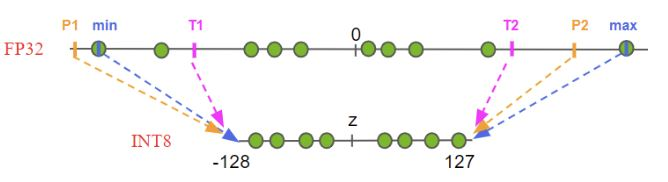


Torch-TensorRT Python API provides an easy and convenient way to use pytorch dataloaders with TensorRT calibrators.
Here we use `min-max` calibration technique

In [ ]:
calibrator = torch_tensorrt.ptq.DataLoaderCalibrator(calib_dataloader,
                                                     use_cache=False,
                                                     algo_type=torch_tensorrt.ptq.CalibrationAlgo.MINMAX_CALIBRATION,
                                                     device=torch.device('cuda:0'))
compile_spec = {
         "inputs": [torch_tensorrt.Input([64, 3, 224, 224])],
         "enabled_precisions": torch.int8,
         "calibrator": calibrator,
         "truncate_long_and_double": True
         }
trt_ptq = torch_tensorrt.compile(baseline_model, **compile_spec)

# Evaluate the PTQ model
test_loss, test_acc = evaluate(trt_ptq, val_dataloader, criterion, 0)
print("Mobilenetv2 PTQ accuracy: {:.2f}%".format(100 * test_acc))

In [ ]:
calibrator = torch_tensorrt.ptq.DataLoaderCalibrator(calib_dataloader,
                                                     use_cache=False,
                                                     algo_type=torch_tensorrt.ptq.CalibrationAlgo.MINMAX_CALIBRATION,
                                                     device=torch.device('cuda:0'))
compile_spec = {
         "inputs": [torch_tensorrt.Input([1, 3, 224, 224])],
         "enabled_precisions": torch.int8,
         "calibrator": calibrator,
         "truncate_long_and_double": True
         }

# benchmark the performance of the PTQ model
trt_ptq_single = torch_tensorrt.compile(baseline_model, **compile_spec)
benchmark(trt_ptq_single, input_shape=(1, 3, 224, 224))

<a id="4"></a>
##  4. Quantization Aware Training

PTQ resulted in a ~4% accuracy drop. After PTQ is performed, sometimes the model may perform poorly by not retaining the accuracy as the process is not able to mitigate the large quantization error induced by low-bit quantization. This could happen if there are sensitive layers in the network, like the Depth wise convolutional networks, in MobileNets which are more susceptible to producing larger quantization error. 

This is when we might want to consider using QAT. The idea behind QAT is simple: you can improve the lost accuracy of the quantized model, if you had trained the model with quantization error. There are many ways of doing this, starting the training of the model from scratch or fine-tuning a pre-trained model. Whatever method you choose, the quantization error is induced in the training loss by inserting fake-quantization operations. The operation is called “fake” because we quantize the data and immediately perform a dequantize operation producing an approximate version of the data where both input and output still remain as floating point values. We are here trying to simulate the effects of quantization without changing much in the model. 
In the forward-pass, we fake-quantize the weights and activations and use these fake-quantized outputs to perform the layer operations.

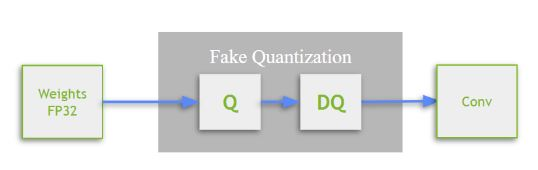

In the backward pass, while calculating gradient, the quantization operation’s derivative is undefined at the step boundaries, and zero everywhere else. To handle this, QAT uses Straight-through Estimator by approximating the derivative to be 1 for inputs in the representable range. This estimator is essentially letting gradients pass as is through this operator in the backward pass. When the QAT process is done, the scales that were used to quantize the weights and activations are stored in the model and can be used for inference. 

We will be using the Pytorch Quantization toolkit, a toolkit built for training and evaluating PyTorch Models with simulated quantization.  

`quant_modules.initialize()` will ensure quantized modules are called instead of original modules. For example, when you define a model with convolution, linear snd pooling layers, you will make a call to `QuantConv2d`, `QuantLinear` and `QuantPooling` respectively. `QuantConv2d` basically wraps quantizer nodes around inputs and weights of regular `Conv2d`. Please refer to all the <a href="https://github.com/NVIDIA/TensorRT/tree/master/tools/pytorch-quantization/pytorch_quantization/nn/modules">quantized modules</a> in pytorch-quantization toolkit for more information. 

In [36]:
quant_modules.initialize()

In [37]:
# We define Mobilenetv2 again just like we did above
# All the regular conv, FC layers will be converted to their quantized counterparts due to quant_modules.initialize()
feature_extract = False
q_model = models.mobilenet_v2(pretrained=True)
set_parameter_requires_grad(q_model, feature_extract)
q_model.classifier[1] = nn.Linear(1280, 10)
q_model = q_model.cuda()

# mobilenetv2_base_ckpt is the checkpoint generated from Step 2 : Training a baseline Mobilenetv2 model.
ckpt = torch.load("./mobilenetv2_base_ckpt")
modified_state_dict={}
for key, val in ckpt["model_state_dict"].items():
    # Remove 'module.' from the key names
    if key.startswith('module'):
        modified_state_dict[key[7:]] = val
    else:
        modified_state_dict[key] = val

# Load the pre-trained checkpoint
q_model.load_state_dict(modified_state_dict)
optimizer.load_state_dict(ckpt["opt_state_dict"])

In [38]:
def compute_amax(model, **kwargs):
    # Load calib result
    for name, module in model.named_modules():
        if isinstance(module, quant_nn.TensorQuantizer):
            if module._calibrator is not None:
                if isinstance(module._calibrator, calib.MaxCalibrator):
                    module.load_calib_amax()
                else:
                    module.load_calib_amax(**kwargs)
    model.cuda()

def collect_stats(model, data_loader, num_batches):
    """Feed data to the network and collect statistics"""
    # Enable calibrators
    for name, module in model.named_modules():
        if isinstance(module, quant_nn.TensorQuantizer):
            if module._calibrator is not None:
                module.disable_quant()
                module.enable_calib()
            else:
                module.disable()

    # Feed data to the network for collecting stats
    for i, (image, _) in tqdm(enumerate(data_loader), total=num_batches):
        model(image.cuda())
        if i >= num_batches:
            break

    # Disable calibrators
    for name, module in model.named_modules():
        if isinstance(module, quant_nn.TensorQuantizer):
            if module._calibrator is not None:
                module.enable_quant()
                module.disable_calib()
            else:
                module.enable()

In [ ]:
#Calibrate the model using percentile calibration technique.
with torch.no_grad():
    collect_stats(q_model, train_dataloader, num_batches=32)
    compute_amax(q_model, method="max")

Usually the finetuning of QAT model should be quick compared to the full training of the original model. For this Mobilenetv2 model, it is enough to finetune for 2 epochs to get acceptable accuracy. 

<a href="https://github.com/NVIDIA/TensorRT/blob/8.0.1/tools/pytorch-quantization/pytorch_quantization/tensor_quant.py">tensor_quant function</a> in `pytorch_quantization` toolkit is responsible for the above tensor quantization. Usually, per channel quantization is recommended for weights, while per tensor quantization is recommended for activations in a network.


In [ ]:
# Finetune the QAT model for 2 epochs
num_epochs=2
lr = 0.001
for epoch in range(num_epochs):
    print('Epoch: [%5d / %5d] LR: %f' % (epoch + 1, num_epochs, lr))

    train(q_model, train_dataloader, criterion, optimizer, epoch)
    test_loss, test_acc = evaluate(q_model, val_dataloader, criterion, epoch)

    print("Test Loss: {:.5f} Test Acc: {:.2f}%".format(test_loss, 100 * test_acc))
    
save_checkpoint({'epoch': epoch + 1,
                 'model_state_dict': q_model.state_dict(),
                 'acc': test_acc,
                 'opt_state_dict': optimizer.state_dict()
                },
                ckpt_path="mobilenetv2_qat_ckpt")

As you can see, accuracy recovered by ~2%. Fine-tuning for more epochs with learning rate annealing can improve accuracy further. It should be noted that the same fine-tuning schedule will improve the accuracy of the unquantized model as well. Please refer to <a href="https://developer.nvidia.com/blog/achieving-fp32-accuracy-for-int8-inference-using-quantization-aware-training-with-tensorrt/">Achieving FP32 Accuracy for INT8 Inference Using Quantization Aware Training with NVIDIA TensorRT</a> for detailed recommendations.

During inference, we use `torch.fake_quantize_per_tensor_affine` and `torch.fake_quantize_per_channel_affine` to perform quantization as this is easier to convert into corresponding TensorRT operators. 

Let us now prepare this model to export it into TorchScript. Setting `quant_nn.TensorQuantizer.use_fb_fake_quant = True` enables the QAT model to use `torch.fake_quantize_per_tensor_affine` and `torch.fake_quantize_per_channel_affine` operators instead of `tensor_quant` function to export quantization operators. In torchscript, they are represented as `aten::fake_quantize_per_tensor_affine` and `aten::fake_quantize_per_channel_affine`. 

In [ ]:
quant_nn.TensorQuantizer.use_fb_fake_quant = True
with torch.no_grad():
    data = iter(val_dataloader)
    images, _ = next(data)
    jit_model = torch.jit.trace(q_model, images.to("cuda"))
    torch.jit.save(jit_model, "mobilenetv2_qat.jit.pt")

In [ ]:
#Loading the Torchscript model and compiling it into a TensorRT model
qat_model = torch.jit.load("mobilenetv2_qat.jit.pt").eval()

compile_spec = {"inputs": [torch_tensorrt.Input([64, 3, 224, 224])],
                "enabled_precisions": torch.int8}
trt_qat = torch_tensorrt.compile(qat_model, **compile_spec)
#Evaluate and benchmark the performance of the QAT-TRT model (TRT INT8)
test_loss, test_acc = evaluate(trt_qat, val_dataloader, criterion, 0)
print("Mobilenetv2 QAT accuracy using TensorRT: {:.2f}%".format(100 * test_acc))

In [ ]:
#benchmark the performance of the QAT-TRT model (TRT INT8)
compile_spec = {"inputs": [torch_tensorrt.Input([1, 3, 224, 224])],
                "enabled_precisions": torch.int8}
trt_qat_single = torch_tensorrt.compile(qat_model, **compile_spec)
benchmark(trt_qat_single, input_shape=(1, 3, 224, 224))

Compared to the TRT FP32 model, we observe a speedup of ~3x  with only a ~1.6% loss in accuracy. 

### Conclusion
We put together all the observations that were made in this notebook. Note that, these numbers can vary with every run due to the stochastic nature of the training process, but a similar pattern can still be noticed.

| Model                    | Accuracy | Performance |
| ------------------------ | -------- | ----------- |
| Baseline MobileNetv2    | 75.56%   | 11.92ms     |
| Base + TRT<br>(TRT FP32) | 75.59%   | 6.78ms      |
| PTQ + TRT<br> (TRT int8) | 71.41%   | 1.57ms      |
| QAT+TRT<br>(TRT INT8)    | 74.00%   | 2.18ms      |

<a id="7"></a>
##  7. References
* <a href="https://arxiv.org/pdf/1409.1556.pdf">Very Deep Convolution Networks for large scale Image Recognition</a>
* <a href="https://developer.nvidia.com/blog/achieving-fp32-accuracy-for-int8-inference-using-quantization-aware-training-with-tensorrt/">Achieving FP32 Accuracy for INT8 Inference Using Quantization Aware Training with NVIDIA TensorRT</a>
* <a href="https://github.com/NVIDIA/TensorRT/tree/master/tools/pytorch-quantization">Pytorch-quantization toolkit from NVIDIA</a>
* <a href="https://docs.nvidia.com/deeplearning/tensorrt/pytorch-quantization-toolkit/docs/userguide.html">Pytorch quantization toolkit userguide</a>
* <a href="https://arxiv.org/pdf/2004.09602.pdf">Quantization basics</a>